In [1]:
import os
from pathlib import Path
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 12-3 (Indexing - Multi-Vector (Hypothetical Questions))"

In [4]:
DATA_PATH = Path('../../data')

# Indexing

![](images/indexing-01.png)

# Part 12-3: Multi-Vector (Hypothetical Questions)

![](images/12-03-multi-vector-hypothetical-questions.png)

## Configure components

In [5]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [6]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKP8jOjsliSWzbirJjgz4RD00oPcX', 'finish_reason': 'stop', 'logprobs': None}, id='run-fda0a3a8-b937-4dd6-821a-48913765747d-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

2

In [10]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [11]:
print(docs[1].page_content[:1000])



      Thinking about High-Quality Human Data
    
Date: February 5, 2024  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng


[Special thank you to Ian Kivlichan for many useful pointers (E.g. the 100+ year old Nature paper “Vox populi”) and nice feedback. 🙏 ]
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data comes from human annotation, such as classification task or RLHF labeling (which can be constructed as classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, but fundamentally human data collection involves attention to details and careful execution. The community knows the value of high quality data, but somehow we have this subtle impression that “Everyone wants to do the model work, not the data work” (Sambasivan et al. 2021).

Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#


In [12]:
[len(doc.page_content) for doc in docs]

[43130, 29018]

## Generate hypothetical questions

In [13]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables import chain
from pydantic import BaseModel, Field

In [14]:
hypothetical_questions_prompt_template = "Generate a list of exactly {hypothetical_questions_count} hypothetical questions that the below document could be used to answer:\n\n{doc}"
print(hypothetical_questions_prompt_template)

Generate a list of exactly {hypothetical_questions_count} hypothetical questions that the below document could be used to answer:

{doc}


In [15]:
class HypotheticalQuestions(BaseModel):
    """Generate hypothetical questions."""

    questions: list[str] = Field(..., description="List of questions")

In [16]:
@chain
def generate_hypothetical_questions(doc, hypothetical_questions_count=3):
    hypothetical_questions_prompt = hypothetical_questions_prompt_template.format(
        hypothetical_questions_count=hypothetical_questions_count,
        doc=doc.page_content
    )
    structured_llm = llm.with_structured_output(HypotheticalQuestions)
    response = structured_llm.invoke([
        HumanMessage(content=hypothetical_questions_prompt)
    ])
    return response.questions

In [17]:
rprint(generate_hypothetical_questions.batch(docs))

[
    [
        'What capabilities would an LLM-powered autonomous agent need to effectively perform complex scientific 
discovery tasks?',
        'How could the integration of self-reflection improve the decision-making process for a large language 
model in autonomous agents?',
        'In what ways can the challenges posed by finite context length impact the performance of LLMs in 
real-world applications?'
    ],
    [
        'What changes might occur in data quality if the majority voting approach is replaced with probabilistic 
graph modeling in human annotation tasks?',
        'How would the performance of machine learning models be affected if diverse perspectives from annotators 
were systematically incorporated during data annotation?',
        'What could be the implications for bias in model training if non-experts were relied upon exclusively to 
annotate complex datasets without expert validation?'
    ]
]

In [18]:
rprint(generate_hypothetical_questions.batch(docs, hypothetical_questions_count=5))

[
    [
        'What would happen if an LLM-powered autonomous agent faced conflicting information when trying to make a 
decision?',
        'How would the performance of an LLM-based agent change if it had infinite long-term memory compared to 
finite memory?',
        'What challenges might arise if an LLM-powered agent were tasked with emotional support rather than 
technical problem-solving?',
        'How would the integration of additional external tools impact the effectiveness of an LLM-powered agent in
a complex task?',
        'If a team of LLM-powered agents were deployed to collaborate on a multifaceted project, what potential 
benefits and drawbacks could arise from their interactions?'
    ],
    [
        'How would the research in this document affect the future of high-stakes AI applications that rely on 
human annotations?',
        'What would happen if the Community prioritized model development over data quality improvements as 
suggested in the document?',
        'What implications could arise if the discrepancies in annotations were acknowledged as valid rather than 
errors, according to the findings mentioned?',
        'How might the techniques for improving data quality impact the reliability of machine learning models 
trained on human-generated data?',
        'What changes could occur in data annotation practices if the contradictory paradigms of prescriptive and 
descriptive annotation were widely adopted?'
    ]
]

In [19]:
hypothetical_questions = generate_hypothetical_questions.batch(docs, {"max_concurrency": len(docs)})
rprint(hypothetical_questions)

[
    [
        'How might LLM-powered autonomous agents address the challenge of finite context length in real-time 
applications?',
        'What implications could the integration of tool use capabilities in LLM agents have on their performance 
in complex task execution?',
        'In what ways could self-reflection mechanisms in LLMs enhance their ability to learn from past mistakes 
during autonomous operations?'
    ],
    [
        'How might the understanding of human data collection methods change if a new, more efficient technique 
were discovered?',
        'What would be the implications for machine learning models if the significance of human subjectivity in 
annotations is further established by future research?',
        'How could the quality control measures for human annotations evolve if AI tools were developed to assist 
in real-time data validation during the annotation process?'
    ]
]

## Store documents

In [20]:
from operator import attrgetter
import uuid

from langchain_core.documents import Document
from langchain_core.stores import InMemoryByteStore
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [21]:
vectorstore = InMemoryVectorStore(embeddings)
store = InMemoryByteStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

question_docs = []

for i, questions in enumerate(hypothetical_questions):
    question_docs.extend(
        [Document(page_content=question, metadata={id_key: doc_ids[i]}) for question in questions]
    )

retriever.vectorstore.add_documents(question_docs)
print(len(question_docs), len(retriever.vectorstore.store))

retriever.docstore.mset(list(zip(doc_ids, docs)))
print(len(doc_ids), len(list(retriever.docstore.store.yield_keys())))

6 6
2 2


In [22]:
agent_query = "What is task decomposition for LLM agents?"
human_data_query = "What are main steps for collecting human data?"

In [23]:
response = retriever.vectorstore.similarity_search(agent_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

response = retriever.invoke(agent_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

[
    Document(
        id='df048473-f854-4e20-9bbc-d1c8f8677ea9',
        metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
        page_content='What implications could the integration of tool use capabilities in LLM agents have on their 
perform'+31
    ),
    Document(
        id='268d0df0-5cc8-48d7-8aa1-2090f01ac10a',
        metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
        page_content='How might LLM-powered autonomous agents address the challenge of finite context length in 
real-time '+13
    ),
    Document(
        id='7c29ec00-e7de-4609-8b69-10f3949718e0',
        metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
        page_content='In what ways could self-reflection mechanisms in LLMs enhance their ability to learn from 
past mista'+33
    ),
    Document(
        id='0c33b88f-0594-48d2-8912-19ea2c2ceb88',
        metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
        page_content='What would be the implications for machine learning models if the significance of human 
subjectivity'+58
    )
]

[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  Estimated 
Reading Tim'+28918
    )
]

In [24]:
response = retriever.vectorstore.similarity_search(human_data_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

response = retriever.invoke(human_data_query)
rprint(Pretty(response, max_string=100, no_wrap=False))

[
    Document(
        id='a62993bc-8939-4c59-b61c-3487f259d5da',
        metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
        page_content='How might the understanding of human data collection methods change if a new, more efficient 
techniq'+19
    ),
    Document(
        id='d6eddc3b-5c06-4adf-80fa-3754c04c2ea7',
        metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
        page_content='How could the quality control measures for human annotations evolve if AI tools were 
developed to as'+64
    ),
    Document(
        id='0c33b88f-0594-48d2-8912-19ea2c2ceb88',
        metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
        page_content='What would be the implications for machine learning models if the significance of human 
subjectivity'+58
    ),
    Document(
        id='df048473-f854-4e20-9bbc-d1c8f8677ea9',
        metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
        page_content='What implications could the integration of tool use capabilities in LLM agents have on their 
perform'+31
    )
]

[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
        page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  Estimated 
Reading Tim'+28918
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
    )
]

## RAG

In [25]:
from typing import TypedDict

from langchain_core.documents import Document
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import HumanMessage

In [26]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}


In [27]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [28]:
class State(TypedDict):
    question: str
    search_results: list[Document]
    context: list[Document]
    answer: str

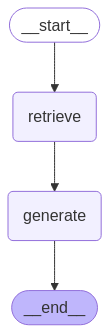

In [29]:
def retrieve(state: State):
    search_results = retriever.vectorstore.similarity_search(state["question"])
    retrieved_docs = retriever.invoke(state["question"])
    return {
        "search_results": search_results,
        "context": retrieved_docs
    }

def generate(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
graph

In [30]:
print(agent_query)
response = graph.invoke({"question": agent_query})
rprint(Pretty(response, max_string=100, no_wrap=False))
rprint(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'search_results': [
        Document(
            id='df048473-f854-4e20-9bbc-d1c8f8677ea9',
            metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
            page_content='What implications could the integration of tool use capabilities in LLM agents have on 
their perform'+31
        ),
        Document(
            id='268d0df0-5cc8-48d7-8aa1-2090f01ac10a',
            metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
            page_content='How might LLM-powered autonomous agents address the challenge of finite context length in
real-time '+13
        ),
        Document(
            id='7c29ec00-e7de-4609-8b69-10f3949718e0',
            metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
            page_content='In what ways could self-reflection mechanisms in LLMs enhance their ability to learn from
past mista'+33
        ),
        Document(
            id='0c33b88f-0594-48d2-8912-19ea2c2ceb88',
            metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
            page_content='What would be the implications for machine learning models if the significance of human 
subjectivity'+58
        )
    ],
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  
Estimated Reading Tim'+28918
        )
    ],
    'answer': 'Task decomposition for LLM (large language model) agents is the process of breaking down complex 
tas'+1758
}

Task decomposition for LLM (large language model) agents is the process of breaking down complex tasks into        
smaller, manageable subgoals or steps. This is important for LLM-powered autonomous agents as it enables them to   
handle complicated tasks more efficiently and effectively. The key concepts involved in task decomposition include:

 1 Subgoal Identification: The agent identifies specific subgoals that must be achieved to complete the larger     
   task. This often involves prompting the model with questions like "What are the subgoals for achieving XYZ?" or 
   providing task-specific instructions.                                                                           
 2 Chain of Thought (CoT): A prompting technique that encourages the model to think step by step, making its       
   thought process more transparent and organized. By utilizing CoT, the model can decompose difficult tasks into  
   simpler ones and articulate the reasoning behind its decisions.                                                 
 3 Tree of Thoughts: An extension of CoT that allows the model to explore multiple reasoning possibilities at each 
   step. It organizes the reasoning process into a tree structure where each thought can branch out to explore     
   different paths or actions.                                                                                     
 4 LLM+P Approach: This approach involves the use of an external classical planner to perform long-horizon         
   planning. The LLM translates the problem into a format known as PDDL (Planning Domain Definition Language),     
   allows the planner to create a plan, and then translates that plan back into natural language.                  
 5 Human Inputs: Human intervention can also assist in task decomposition by providing clarity or additional       
   context for complex tasks, which may not be easily broken down by the model alone.                              

By effectively utilizing task decomposition, LLM agents can enhance their performance on complex problems, improve 
reliability in executing tasks, and obtain better results in various applications.

In [31]:
print(human_data_query)
response = graph.invoke({"question": human_data_query})
rprint(Pretty(response, max_string=100, no_wrap=False))
rprint(Markdown(response["answer"]))

What are main steps for collecting human data?


{
    'question': 'What are main steps for collecting human data?',
    'search_results': [
        Document(
            id='a62993bc-8939-4c59-b61c-3487f259d5da',
            metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
            page_content='How might the understanding of human data collection methods change if a new, more 
efficient techniq'+19
        ),
        Document(
            id='d6eddc3b-5c06-4adf-80fa-3754c04c2ea7',
            metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
            page_content='How could the quality control measures for human annotations evolve if AI tools were 
developed to as'+64
        ),
        Document(
            id='0c33b88f-0594-48d2-8912-19ea2c2ceb88',
            metadata={'doc_id': '0d92fccc-9d76-4edb-9067-ef3fbe824ec4'},
            page_content='What would be the implications for machine learning models if the significance of human 
subjectivity'+58
        ),
        Document(
            id='df048473-f854-4e20-9bbc-d1c8f8677ea9',
            metadata={'doc_id': '530a8eea-8510-4afd-8582-93ad3a5cbd6d'},
            page_content='What implications could the integration of tool use capabilities in LLM agents have on 
their perform'+31
        )
    ],
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='\n\n      Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  
Estimated Reading Tim'+28918
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading 
Time: 31 min  |'+43030
        )
    ],
    'answer': 'The main steps for collecting human data, as outlined in the provided context, are:\n\n1. **Task 
Desig'+900
}

The main steps for collecting human data, as outlined in the provided context, are:                                

 1 Task Design: Create a clear task workflow to enhance clarity and reduce complexity. This involves providing     
   detailed guidelines that are straightforward enough to be useful without being overly complicated.              
 2 Select and Train a Pool of Raters: Identify annotators with the appropriate skill set and ensure consistency in 
   their annotations. This requires conducting training sessions to educate raters about the task. After           
   onboarding, regular feedback and calibration sessions should be implemented to maintain quality.                
 3 Collect and Aggregate Data: This step involves the collection of annotations from the human raters, followed by 
   the application of machine learning techniques to clean, filter, and intelligently aggregate the data to        
   determine the true labels.                                                                                      

These steps emphasize the importance of careful execution throughout the data collection process to ensure         
high-quality outcomes.